In [5]:

# Import Libraries
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
# A class that models the Neural Net with L-layers and
# N neurons in each layer. It also contains the functions
# for training, testing, and optimizing the Neural Network

np.random.seed(100)

class DeepNN:

    # Constructor to build the structure of the Neural Network
    # It accepts the layers in the format of [2,3,1] -> 2 Neuron Input Layer,
    # 3 Neuron Hidden Layer and 1 Neuron output layer
    def __init__(self, layers, activations):
        ############################### Initialize the number of layers and neurons
        self.layers = layers
        self.num_layers = len(layers)
        self.hidden_layers = len(layers) - 2
        self.input_neurons = layers[0]
        self.output_neurons = layers[-1]

        ########## Intialize parameters for Forward Propogation
        # Initialize Weights
        self.epsilon = 0.12  # Random Weight Initialization Factor
        self.weights = []
        for i in range(self.num_layers-2):
            self.weights.append(np.random.randn(layers[i]+1, layers[i+1]+1)*2*self.epsilon - self.epsilon)
                        # We add a +1 to incorporate for weights from the +1 neuron for the bias
        self.weights.append(np.random.randn(layers[-2]+1, layers[-1])*2*self.epsilon - self.epsilon)

        self.a = [] # To keep track of activations
        self.z = [] # To keep track of layer values
        self.activations = activations # Activations for each layer

        ######### Intialize parameters for Backward Propogation
        self.delta = []
        self.gradient = []

        # Initialize Scaling
        self.scaler = preprocessing.StandardScaler()

    ################################### Define Some Activation Functions and their derivatives ##################
    def sigmoid(self,x):
        return 1.0/(1.0 + np.exp(-x))

    def sigmoidPrime(self,x):
        return self.sigmoid(x)*(1-self.sigmoid(x))

    def reLU(self,x):
        return np.maximum(x, 0)

    def reLUPrime(self,x):
        return np.where(x > 0, 1.0, 0.0)

    def softmax(self,x):
        return np.exp(x)/np.sum(np.exp(x), axis = 0)

    def tanh(self,x):
        return np.tanh(x)

    def tanh_prime(self,x):
        return 1 - np.power(np.tanh(x),2)

    def identity(self,x):
        return x

    def identity_prime(self,x):
        return 1

    ######################################### Cost Functions #############################################
    # Least Squares
    def least_squares_cost(self,t):
        return 0.5*np.mean( (t-self.a[-1])**2 )

    # Cross Entropy Log Loss Function
    def log_loss(self,t):
        return np.mean( np.nan_to_num( -1*t*np.log(self.a[-1]) - (1-t)*np.log(1-self.a[-1]) ) )

    ######################################### Forward Feed ##############################################
    def forwardFeed(self, X):
        a = [X] # Keep Track of activations
        z = []

        # Add Bias
        c = np.ones([1,a[0].shape[0]]).reshape(a[0].shape[0],1)
        a[0] = np.concatenate((c,a[0]), axis=1)
#         print(a)
        for i in range(self.num_layers-1):
#             print(a[i])
            z.append(np.dot(a[i],self.weights[i]))
            if(self.activations[i] == 'sigmoid'):
                a.append(self.sigmoid(z[i]))
            elif(self.activations[i] == 'reLU'):
                a.append(self.reLU(z[i]))
            elif(self.activations[i] == 'tanh'):
                a.append(self.tanh(z[i]))
            elif(self.activations[i] == 'softmax'):
                a.append(self.softmax(z[i]))
            elif(self.activations[i] == 'identity'):
                a.append(self.identity(z[i]))
        self.a = a
        self.z = z

    def backPropogate(self,y):

        delta = []
        gradient = []
        weights_flipped = self.weights[::-1]
        z_flipped = self.z[::-1]
        activations_flipped = self.a[::-1]
        activation_func_flipped = self.activations[::-1]
        delta.append(activations_flipped[0] - y)
        for i in range(0,self.num_layers-2):
                if(activation_func_flipped[i] == 'sigmoid'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T ) * self.sigmoidPrime(z_flipped[i+1]) )
                elif(activation_func_flipped[i] == 'reLU'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T ) * self.reLUPrime(z_flipped[i+1]) )
                elif(activation_func_flipped[i] == 'tanh'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T ) * self.tanh_prime(z_flipped[i+1]) )
                elif(activation_func_flipped[i] == 'identity'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T ) * self.identity_prime(z_flipped[i+1]) )
                elif(activation_func_flipped[i] == 'softmax'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T))

        delta = delta[::-1]

        for i in range(len(delta)):
            gradient.append( np.dot(self.a[i].T, delta[i]) )
            
        self.delta = delta
        self.gradient = gradient

    def learn(self, epochs, learning_rate, X, y, cost_func, metrics_at=10, optimizer = '', batch_size=10, scaler_type='standard_scaler', split=False, test_size=0.25, beta = 0.9, beta_2 = 0.99, epsilon=10e-8):
        start = time.time()
        
        cost=[]
        
        v_n = []
        s_n = []
        for j in range(len(self.weights)):
            v_n.append(np.zeros(self.weights[j].shape))
            s_n.append(np.zeros(self.weights[j].shape))
            
        if scaler_type == 'min_max_scaler':
            self.scaler = preprocessing.MinMaxScaler()
        X = self.scaler.fit_transform(X)

        if split:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
            X = X_train
            y = y_train

        
        for i in range(epochs):
                if optimizer == 'mini_batch':
                    # Batch size of 1 makes it SGD
                    no_of_batches = int(len(X)/batch_size)
                    for k in range(no_of_batches):
                        if k==no_of_batches-1:
                            X_sgd = X[k*batch_size:]
                            y_sgd = y[k*batch_size:]
                        else:
                            X_sgd = X[k*batch_size:(k+1)*batch_size]
                            y_sgd = y[k*batch_size:(k+1)*batch_size]
                        self.forwardFeed(X_sgd)
                        self.backPropogate(y_sgd)
                        for j in range(len(self.gradient)):
                            v_n[j] = beta * v_n[j] + (1-beta) * self.gradient[j]
                            self.weights[j] = self.weights[j] - learning_rate * v_n[j]
                elif optimizer == 'rmsprop':
                    # Batch size of 1 makes it SGD
                    no_of_batches = int(len(X)/batch_size)
                    for k in range(no_of_batches):
                        if k==no_of_batches-1:
                            X_sgd = X[k*batch_size:]
                            y_sgd = y[k*batch_size:]
                        else:
                            X_sgd = X[k*batch_size:(k+1)*batch_size]
                            y_sgd = y[k*batch_size:(k+1)*batch_size]
                            
                        self.forwardFeed(X_sgd)
                        self.backPropogate(y_sgd)
                        for j in range(len(self.gradient)):
                            s_n[j] = beta_2 * s_n[j] + (1-beta_2) * np.power(self.gradient[j],2)
                            self.weights[j] = self.weights[j] - learning_rate * self.gradient[j]/np.sqrt(s_n[j]+epsilon)
                elif optimizer == 'adam':
                    # Batch size of 1 makes it SGD
                    no_of_batches = int(len(X)/batch_size)
                    for k in range(no_of_batches):
                        if k==no_of_batches-1:
                            X_sgd = X[k*batch_size:]
                            y_sgd = y[k*batch_size:]
                        else:
                            X_sgd = X[k*batch_size:(k+1)*batch_size]
                            y_sgd = y[k*batch_size:(k+1)*batch_size]
                        self.forwardFeed(X_sgd)
                        self.backPropogate(y_sgd)
                        for j in range(len(self.gradient)):
                            v_n[j] = beta * v_n[j] + (1-beta) * self.gradient[j]
                            s_n[j] = beta_2 * s_n[j] + (1-beta_2) * np.power(self.gradient[j],2)
                            
                            # Beta Correction
                            v_n[j] = v_n[j] / (1-np.power(beta,k)+epsilon)
                            s_n[j] = s_n[j] / (1-np.power(beta_2,k)+epsilon)
                            
                            self.weights[j] = self.weights[j] - learning_rate * v_n[j]/np.sqrt(s_n[j]+epsilon)

                else:
                    self.forwardFeed(X)
                    self.backPropogate(y)
                    for j in range(len(self.gradient)):
                        self.weights[j] = self.weights[j] - learning_rate * self.gradient[j]

                if(i%metrics_at == 0):
                    self.forwardFeed(X)
                    print('Effective epoch: ', i/metrics_at + 1)
                    if(cost_func == 'log_loss'):
                        cost.append(self.log_loss(y))
                        print('Accuracy: ', np.mean(np.round(self.think(X))==y) * 100, '%')
                    elif(cost_func == 'least_squares'):
                        cost.append(self.least_squares_cost(y))
                    print('Cost: ', cost[-1], '\n')

        

        end = time.time()
        
        
        if(cost_func == 'log_loss' and split):
            print('Testing Accuracy: ', np.mean(np.round(self.think(X_test))==y_test) * 100, '%')
        plt.plot(cost)
        print('Time Taken: ', end-start, ' seconds')
        return self.weights

    def think(self,X):
        #X = self.scaler.fit_transform(X)
        a = [X] # Keep Track of activations
        z = []

        # Add Bias
        c = np.ones([1,a[0].shape[0]]).reshape(a[0].shape[0],1)
        a[0] = np.concatenate((c,a[0]), axis=1)
#         print(a)
        for i in range(self.num_layers-1):
#             print(a[i])
            z.append(np.dot(a[i],self.weights[i]))
            if(self.activations[i] == 'sigmoid'):
                a.append(self.sigmoid(z[i]))
            elif(self.activations[i] == 'reLU'):
                a.append(self.reLU(z[i]))
            elif(self.activations[i] == 'tanh'):
                a.append(self.tanh(z[i]))
            elif(self.activations[i] == 'softmax'):
                a.append(self.softmax(z[i]))
            elif(self.activations[i] == 'identity'):
                a.append(self.identity(z[i]))
                
        return a[-1]


Effective epoch:  1.0
Cost:  0.32030923486728846 

Effective epoch:  2.0
Cost:  0.2518972377399882 

Effective epoch:  3.0
Cost:  0.2519592349359659 

Effective epoch:  4.0
Cost:  0.25175617493674657 

Effective epoch:  5.0
Cost:  0.25165531806145724 

Effective epoch:  6.0
Cost:  0.25156803271828027 

Effective epoch:  7.0
Cost:  0.2515019763916298 

Effective epoch:  8.0
Cost:  0.25150531876988924 

Effective epoch:  9.0
Cost:  0.25150651834465837 

Effective epoch:  10.0
Cost:  0.2515055778446806 

Time Taken:  4.962832927703857  seconds


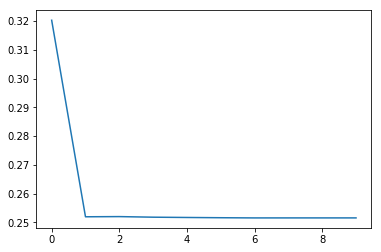

In [6]:
# Part - b Generate Dataset
np.random.seed(100)
X = np.sort(2*np.random.rand(50,1)-1)
t = np.sin(2*(np.pi)*X) + 0.3*np.random.randn(50,1)

# Build NN
NN2 = DeepNN([1,2,1], activations=['reLU','identity'])
w = NN2.learn(epochs=100000, learning_rate=0.001, X=X, y=t, cost_func='least_squares', metrics_at=10000, optimizer='rmsprop',batch_size=32)

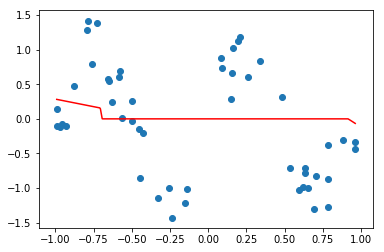

In [7]:
# plot the model
x_mesh = np.linspace(np.min(X),np.max(X),500).reshape(500,1)
y = NN2.think(x_mesh)

plt.plot(x_mesh,y,'r')
# plt.plot(X,t)
plt.scatter(X,t)

In [8]:
# from keras.models import Sequential
# from keras.layers import Dense, Activation

# model = Sequential([
#     Dense(32, input_shape=(1,)),
#     Dense(20),
#     Activation('tanh'),
# #     Dense(20),
# #     Activation('relu'),
#     Dense(1),
#     Activation('linear'),
# ])

# model.compile(optimizer='rmsprop',
#               loss='mean_squared_error')

# model.fit(X, t, epochs=50, batch_size=32)
# model.build()
# model.summary()

# y = model.predict(x_mesh)
# plt.plot(x_mesh,y,'r')
# plt.scatter(X,t)

Effective epoch:  1.0
Accuracy:  25.0 %
Cost:  0.7062942092743879 

Effective epoch:  2.0
Accuracy:  25.0 %
Cost:  0.7040777061590752 

Effective epoch:  3.0
Accuracy:  25.0 %
Cost:  0.7021926029124683 

Effective epoch:  4.0
Accuracy:  25.0 %
Cost:  0.7005869555251253 

Effective epoch:  5.0
Accuracy:  25.0 %
Cost:  0.6992170798863404 

Effective epoch:  6.0
Accuracy:  25.0 %
Cost:  0.698046194305932 

Effective epoch:  7.0
Accuracy:  25.0 %
Cost:  0.6970432940852076 

Effective epoch:  8.0
Accuracy:  50.0 %
Cost:  0.6961822166237277 

Effective epoch:  9.0
Accuracy:  50.0 %
Cost:  0.6954408632845245 

Effective epoch:  10.0
Accuracy:  50.0 %
Cost:  0.6948005505101862 

Effective epoch:  11.0
Accuracy:  50.0 %
Cost:  0.694245467751679 

Effective epoch:  12.0
Accuracy:  50.0 %
Cost:  0.6937622238682326 

Effective epoch:  13.0
Accuracy:  50.0 %
Cost:  0.6933394669689584 

Effective epoch:  14.0
Accuracy:  50.0 %
Cost:  0.6929675653493962 

Effective epoch:  15.0
Accuracy:  75.0 %
Cost

Accuracy:  75.0 %
Cost:  0.5249187511803844 

Effective epoch:  163.0
Accuracy:  75.0 %
Cost:  0.5223600608318748 

Effective epoch:  164.0
Accuracy:  75.0 %
Cost:  0.5197864936465055 

Effective epoch:  165.0
Accuracy:  75.0 %
Cost:  0.5171984076757102 

Effective epoch:  166.0
Accuracy:  75.0 %
Cost:  0.5145961857895005 

Effective epoch:  167.0
Accuracy:  75.0 %
Cost:  0.5119802350954546 

Effective epoch:  168.0
Accuracy:  75.0 %
Cost:  0.5093509862283471 

Effective epoch:  169.0
Accuracy:  75.0 %
Cost:  0.5067088925156403 

Effective epoch:  170.0
Accuracy:  75.0 %
Cost:  0.5040544290244802 

Effective epoch:  171.0
Accuracy:  75.0 %
Cost:  0.5013880914962534 

Effective epoch:  172.0
Accuracy:  75.0 %
Cost:  0.49871039517519766 

Effective epoch:  173.0
Accuracy:  75.0 %
Cost:  0.49602187353798255 

Effective epoch:  174.0
Accuracy:  75.0 %
Cost:  0.49332307693160443 

Effective epoch:  175.0
Accuracy:  75.0 %
Cost:  0.49061457112734375 

Effective epoch:  176.0
Accuracy:  75.0 

Accuracy:  100.0 %
Cost:  0.20192081472814166 

Effective epoch:  288.0
Accuracy:  100.0 %
Cost:  0.19960364711022183 

Effective epoch:  289.0
Accuracy:  100.0 %
Cost:  0.19729819917150934 

Effective epoch:  290.0
Accuracy:  100.0 %
Cost:  0.19500499094836077 

Effective epoch:  291.0
Accuracy:  100.0 %
Cost:  0.19272453998668332 

Effective epoch:  292.0
Accuracy:  100.0 %
Cost:  0.1904573599576058 

Effective epoch:  293.0
Accuracy:  100.0 %
Cost:  0.18820395930148198 

Effective epoch:  294.0
Accuracy:  100.0 %
Cost:  0.1859648399063475 

Effective epoch:  295.0
Accuracy:  100.0 %
Cost:  0.1837404958266552 

Effective epoch:  296.0
Accuracy:  100.0 %
Cost:  0.18153141204777373 

Effective epoch:  297.0
Accuracy:  100.0 %
Cost:  0.1793380633013577 

Effective epoch:  298.0
Accuracy:  100.0 %
Cost:  0.17716091293628383 

Effective epoch:  299.0
Accuracy:  100.0 %
Cost:  0.17500041184940532 

Effective epoch:  300.0
Accuracy:  100.0 %
Cost:  0.17285699747991382 

Effective epoch:  30

Effective epoch:  412.0
Accuracy:  100.0 %
Cost:  0.04872046231206798 

Effective epoch:  413.0
Accuracy:  100.0 %
Cost:  0.048308404448790386 

Effective epoch:  414.0
Accuracy:  100.0 %
Cost:  0.047902254478435206 

Effective epoch:  415.0
Accuracy:  100.0 %
Cost:  0.04750190539029491 

Effective epoch:  416.0
Accuracy:  100.0 %
Cost:  0.047107252297242136 

Effective epoch:  417.0
Accuracy:  100.0 %
Cost:  0.04671819239711772 

Effective epoch:  418.0
Accuracy:  100.0 %
Cost:  0.04633462493438339 

Effective epoch:  419.0
Accuracy:  100.0 %
Cost:  0.045956451162072184 

Effective epoch:  420.0
Accuracy:  100.0 %
Cost:  0.045583574304068133 

Effective epoch:  421.0
Accuracy:  100.0 %
Cost:  0.04521589951774258 

Effective epoch:  422.0
Accuracy:  100.0 %
Cost:  0.044853333856973154 

Effective epoch:  423.0
Accuracy:  100.0 %
Cost:  0.044495786235566215 

Effective epoch:  424.0
Accuracy:  100.0 %
Cost:  0.04414316739110495 

Effective epoch:  425.0
Accuracy:  100.0 %
Cost:  0.04379

Effective epoch:  537.0
Accuracy:  100.0 %
Cost:  0.02257685498944464 

Effective epoch:  538.0
Accuracy:  100.0 %
Cost:  0.022476788146335927 

Effective epoch:  539.0
Accuracy:  100.0 %
Cost:  0.022377590629743756 

Effective epoch:  540.0
Accuracy:  100.0 %
Cost:  0.022279251753103156 

Effective epoch:  541.0
Accuracy:  100.0 %
Cost:  0.022181760995283538 

Effective epoch:  542.0
Accuracy:  100.0 %
Cost:  0.02208510799755867 

Effective epoch:  543.0
Accuracy:  100.0 %
Cost:  0.02198928256064038 

Effective epoch:  544.0
Accuracy:  100.0 %
Cost:  0.021894274641772515 

Effective epoch:  545.0
Accuracy:  100.0 %
Cost:  0.021800074351886245 

Effective epoch:  546.0
Accuracy:  100.0 %
Cost:  0.02170667195281354 

Effective epoch:  547.0
Accuracy:  100.0 %
Cost:  0.02161405785455783 

Effective epoch:  548.0
Accuracy:  100.0 %
Cost:  0.02152222261262146 

Effective epoch:  549.0
Accuracy:  100.0 %
Cost:  0.021431156925386885 

Effective epoch:  550.0
Accuracy:  100.0 %
Cost:  0.02134

Effective epoch:  662.0
Accuracy:  100.0 %
Cost:  0.014514346676120546 

Effective epoch:  663.0
Accuracy:  100.0 %
Cost:  0.014473369827689757 

Effective epoch:  664.0
Accuracy:  100.0 %
Cost:  0.014432632488800258 

Effective epoch:  665.0
Accuracy:  100.0 %
Cost:  0.014392132607063509 

Effective epoch:  666.0
Accuracy:  100.0 %
Cost:  0.014351868152848394 

Effective epoch:  667.0
Accuracy:  100.0 %
Cost:  0.014311837118974526 

Effective epoch:  668.0
Accuracy:  100.0 %
Cost:  0.01427203752041123 

Effective epoch:  669.0
Accuracy:  100.0 %
Cost:  0.014232467393979969 

Effective epoch:  670.0
Accuracy:  100.0 %
Cost:  0.014193124798062636 

Effective epoch:  671.0
Accuracy:  100.0 %
Cost:  0.014154007812313582 

Effective epoch:  672.0
Accuracy:  100.0 %
Cost:  0.014115114537376757 

Effective epoch:  673.0
Accuracy:  100.0 %
Cost:  0.014076443094606723 

Effective epoch:  674.0
Accuracy:  100.0 %
Cost:  0.014037991625794236 

Effective epoch:  675.0
Accuracy:  100.0 %
Cost:  0.

Effective epoch:  787.0
Accuracy:  100.0 %
Cost:  0.010762278466107066 

Effective epoch:  788.0
Accuracy:  100.0 %
Cost:  0.010740424970744237 

Effective epoch:  789.0
Accuracy:  100.0 %
Cost:  0.010718665774975827 

Effective epoch:  790.0
Accuracy:  100.0 %
Cost:  0.010697000270334246 

Effective epoch:  791.0
Accuracy:  100.0 %
Cost:  0.01067542785350076 

Effective epoch:  792.0
Accuracy:  100.0 %
Cost:  0.01065394792625117 

Effective epoch:  793.0
Accuracy:  100.0 %
Cost:  0.010632559895403487 

Effective epoch:  794.0
Accuracy:  100.0 %
Cost:  0.010611263172765745 

Effective epoch:  795.0
Accuracy:  100.0 %
Cost:  0.010590057175084528 

Effective epoch:  796.0
Accuracy:  100.0 %
Cost:  0.010568941323993792 

Effective epoch:  797.0
Accuracy:  100.0 %
Cost:  0.010547915045964891 

Effective epoch:  798.0
Accuracy:  100.0 %
Cost:  0.010526977772256654 

Effective epoch:  799.0
Accuracy:  100.0 %
Cost:  0.010506128938866665 

Effective epoch:  800.0
Accuracy:  100.0 %
Cost:  0.0


Effective epoch:  912.0
Accuracy:  100.0 %
Cost:  0.008607905915574008 

Effective epoch:  913.0
Accuracy:  100.0 %
Cost:  0.008594361619000936 

Effective epoch:  914.0
Accuracy:  100.0 %
Cost:  0.008580863187173032 

Effective epoch:  915.0
Accuracy:  100.0 %
Cost:  0.00856741038482955 

Effective epoch:  916.0
Accuracy:  100.0 %
Cost:  0.00855400297830574 

Effective epoch:  917.0
Accuracy:  100.0 %
Cost:  0.008540640735520202 

Effective epoch:  918.0
Accuracy:  100.0 %
Cost:  0.00852732342596108 

Effective epoch:  919.0
Accuracy:  100.0 %
Cost:  0.008514050820673367 

Effective epoch:  920.0
Accuracy:  100.0 %
Cost:  0.00850082269224574 

Effective epoch:  921.0
Accuracy:  100.0 %
Cost:  0.00848763881479747 

Effective epoch:  922.0
Accuracy:  100.0 %
Cost:  0.00847449896396621 

Effective epoch:  923.0
Accuracy:  100.0 %
Cost:  0.008461402916894924 

Effective epoch:  924.0
Accuracy:  100.0 %
Cost:  0.008448350452219755 

Effective epoch:  925.0
Accuracy:  100.0 %
Cost:  0.0084

Effective epoch:  1060.0
Accuracy:  100.0 %
Cost:  0.007002381877847148 

Effective epoch:  1061.0
Accuracy:  100.0 %
Cost:  0.006993712374336189 

Effective epoch:  1062.0
Accuracy:  100.0 %
Cost:  0.006985066109440389 

Effective epoch:  1063.0
Accuracy:  100.0 %
Cost:  0.006976442987845691 

Effective epoch:  1064.0
Accuracy:  100.0 %
Cost:  0.006967842914758776 

Effective epoch:  1065.0
Accuracy:  100.0 %
Cost:  0.006959265795904082 

Effective epoch:  1066.0
Accuracy:  100.0 %
Cost:  0.006950711537520028 

Effective epoch:  1067.0
Accuracy:  100.0 %
Cost:  0.006942180046355574 

Effective epoch:  1068.0
Accuracy:  100.0 %
Cost:  0.00693367122966674 

Effective epoch:  1069.0
Accuracy:  100.0 %
Cost:  0.006925184995213213 

Effective epoch:  1070.0
Accuracy:  100.0 %
Cost:  0.0069167212512551484 

Effective epoch:  1071.0
Accuracy:  100.0 %
Cost:  0.006908279906549283 

Effective epoch:  1072.0
Accuracy:  100.0 %
Cost:  0.006899860870346284 

Effective epoch:  1073.0
Accuracy:  10

Effective epoch:  1197.0
Accuracy:  100.0 %
Cost:  0.005997389648280593 

Effective epoch:  1198.0
Accuracy:  100.0 %
Cost:  0.0059911935048159665 

Effective epoch:  1199.0
Accuracy:  100.0 %
Cost:  0.005985011234023891 

Effective epoch:  1200.0
Accuracy:  100.0 %
Cost:  0.005978842788091262 

Effective epoch:  1201.0
Accuracy:  100.0 %
Cost:  0.005972688119425806 

Effective epoch:  1202.0
Accuracy:  100.0 %
Cost:  0.005966547180654867 

Effective epoch:  1203.0
Accuracy:  100.0 %
Cost:  0.005960419924623932 

Effective epoch:  1204.0
Accuracy:  100.0 %
Cost:  0.005954306304395534 

Effective epoch:  1205.0
Accuracy:  100.0 %
Cost:  0.005948206273248057 

Effective epoch:  1206.0
Accuracy:  100.0 %
Cost:  0.005942119784674294 

Effective epoch:  1207.0
Accuracy:  100.0 %
Cost:  0.005936046792380267 

Effective epoch:  1208.0
Accuracy:  100.0 %
Cost:  0.005929987250284337 

Effective epoch:  1209.0
Accuracy:  100.0 %
Cost:  0.0059239411125156845 

Effective epoch:  1210.0
Accuracy:  

Effective epoch:  1328.0
Accuracy:  100.0 %
Cost:  0.00528857071463876 

Effective epoch:  1329.0
Accuracy:  100.0 %
Cost:  0.005283852941570592 

Effective epoch:  1330.0
Accuracy:  100.0 %
Cost:  0.005279144277372407 

Effective epoch:  1331.0
Accuracy:  100.0 %
Cost:  0.005274444694870244 

Effective epoch:  1332.0
Accuracy:  100.0 %
Cost:  0.005269754166999286 

Effective epoch:  1333.0
Accuracy:  100.0 %
Cost:  0.005265072666803202 

Effective epoch:  1334.0
Accuracy:  100.0 %
Cost:  0.005260400167433625 

Effective epoch:  1335.0
Accuracy:  100.0 %
Cost:  0.0052557366421495735 

Effective epoch:  1336.0
Accuracy:  100.0 %
Cost:  0.005251082064317006 

Effective epoch:  1337.0
Accuracy:  100.0 %
Cost:  0.005246436407408177 

Effective epoch:  1338.0
Accuracy:  100.0 %
Cost:  0.005241799645000896 

Effective epoch:  1339.0
Accuracy:  100.0 %
Cost:  0.005237171750778695 

Effective epoch:  1340.0
Accuracy:  100.0 %
Cost:  0.005232552698529511 

Effective epoch:  1341.0
Accuracy:  10

Accuracy:  100.0 %
Cost:  0.004735566363529956 

Effective epoch:  1461.0
Accuracy:  100.0 %
Cost:  0.004731851142983683 

Effective epoch:  1462.0
Accuracy:  100.0 %
Cost:  0.0047281422157667745 

Effective epoch:  1463.0
Accuracy:  100.0 %
Cost:  0.004724439565369729 

Effective epoch:  1464.0
Accuracy:  100.0 %
Cost:  0.004720743175341261 

Effective epoch:  1465.0
Accuracy:  100.0 %
Cost:  0.004717053029288489 

Effective epoch:  1466.0
Accuracy:  100.0 %
Cost:  0.004713369110876213 

Effective epoch:  1467.0
Accuracy:  100.0 %
Cost:  0.004709691403827099 

Effective epoch:  1468.0
Accuracy:  100.0 %
Cost:  0.004706019891921074 

Effective epoch:  1469.0
Accuracy:  100.0 %
Cost:  0.004702354558995145 

Effective epoch:  1470.0
Accuracy:  100.0 %
Cost:  0.004698695388943377 

Effective epoch:  1471.0
Accuracy:  100.0 %
Cost:  0.004695042365716327 

Effective epoch:  1472.0
Accuracy:  100.0 %
Cost:  0.0046913954733211315 

Effective epoch:  1473.0
Accuracy:  100.0 %
Cost:  0.00468775

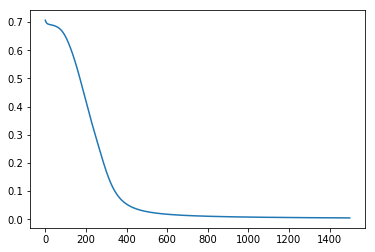

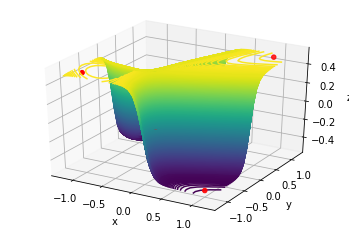

In [9]:


########################## Part a) - Generate Dataset
X = np.array([[-1, -1],[1, 1],[-1, 1],[1, -1]],dtype='float')
t = np.array([1, 1, 0, 0],dtype='float').reshape(4,1)


NN = DeepNN([2,2,1], activations=['tanh','sigmoid'])

w = NN.learn(epochs=1500, learning_rate=0.1, X=X, y=t, cost_func='log_loss', metrics_at=1, split=False)
print('Accuracy: ',np.mean(np.round(NN.think(X))==t) * 100)


x_mesh = np.linspace(-1.2,1.2,30).reshape(30,1)
y_mesh = np.linspace(-1.2,1.2,30).reshape(30,1)

X_mesh, Y_mesh = np.meshgrid(x_mesh,x_mesh)
X_test = np.hstack((x_mesh,y_mesh))



# Classify Points for Decision Boundary
predicitions = np.zeros([len(x_mesh),len(y_mesh)])
for i in range(len(X_mesh)):
    for j in range(len(Y_mesh)):
        pnt = np.array([X_mesh[i,j],Y_mesh[i,j]]).reshape(1,2)
        predicitions[i,j] = NN.think(pnt)[0,0]



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X_mesh, Y_mesh, predicitions-0.5,1000)

x_xor = [-1, 1, -1, 1]
y_xor = [-1, 1, 1, -1]
t_xor = [0.5, 0.5, -0.5, -0.5]
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(x_xor, y_xor, t_xor, c='r')
plt.show()

In [12]:
predicitions

array([[0.98245203, 0.989314  , 0.99366171, 0.9960965 , 0.99736556,
        0.9979854 , 0.998232  , 0.99822051, 0.99795497, 0.99731796,
        0.99595641, 0.99289102, 0.98521944, 0.96374425, 0.90012666,
        0.73244402, 0.44739599, 0.20373195, 0.08518627, 0.03900184,
        0.02080973, 0.01292715, 0.00912451, 0.00710868, 0.00595602,
        0.00525697, 0.00481321, 0.0045211 , 0.004323  , 0.00418518],
       [0.99001478, 0.9937351 , 0.9962113 , 0.99764559, 0.99840187,
        0.9987611 , 0.99887657, 0.99879844, 0.99848135, 0.99772419,
        0.99592482, 0.99121217, 0.97730996, 0.93297901, 0.80113009,
        0.53217307, 0.25623211, 0.10766708, 0.04835823, 0.02516236,
        0.01524816, 0.01052098, 0.00803249, 0.00661164, 0.0057463 ,
        0.0051916 , 0.00482102, 0.00456483, 0.0043825 , 0.00424945],
       [0.99414389, 0.99626988, 0.99772952, 0.99859301, 0.99904988,
        0.99925966, 0.99930853, 0.99920995, 0.99888477, 0.99804396,
        0.99572963, 0.98852574, 0.96369157, 0.